# Basic Model

In [37]:
%pwd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import utils
%matplotlib inline

In [38]:
base_path = '/home/ubuntu/data/statefarm/imags/' #imags/samples
train_path = base_path + 'train'
val_path = base_path + 'valid'
test_path = base_path + 'test'
weight_path = '/home/ubuntu/data/weights/statefarm/'
sub_path = '/home/ubuntu/fastai_course/neilz/part1/sub/statefarm/'

In [39]:
import vgg16; reload(vgg16)

<module 'vgg16' from 'vgg16.pyc'>

# Apply Pre-Trained Convolution Layers

In [40]:
import utils
mid_train_data = utils.load_array(weight_path + '/statefarm_conv_res')
mid_val_data = utils.load_array(weight_path + '/statefarm_conv_val')
mid_test_data = utils.load_array(weight_path + '/statefarm_conv_test')

In [41]:
val_classes, train_classes, val_labels, train_labels, \
        val_filenames, train_filenames, test_filenames = utils.get_classes(base_path)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [42]:
print(mid_train_data.shape)

(17943, 25088)


In [43]:
#Construct a new model with just FCBs and using the convoluation results from Vgg16 as input
#I want to overfit the train data first, so I use 2 dense layers total 4096*4096+4096 (bias) parameters without dropout
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
lr = 0.001
statefarm_model = Sequential()
statefarm_model.add(BatchNormalization(axis=1, input_shape=(25088,)))
statefarm_model.add(Dense(256, activation='relu')) #, input_shape=(25088,)))
statefarm_model.add(BatchNormalization(axis=1))
statefarm_model.add(Dropout(0.5)) 
statefarm_model.add(Dense(10, activation='softmax'))
statefarm_model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
statefarm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 25088)             100352    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               6422784   
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                2570      
Total params: 6,526,730
Trainable params: 6,476,042
Non-trainable params: 50,688
_________________________________________________________________


In [41]:
from keras import backend as K
K.set_value(statefarm_model.optimizer.lr, 0.0001)
print(statefarm_model.optimizer.get_config())
statefarm_model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

{'beta_1': 0.8999999761581421, 'epsilon': 1e-08, 'beta_2': 0.9990000128746033, 'lr': 9.999999747378752e-05, 'decay': 0.0}


In [44]:
from keras.callbacks import ModelCheckpoint
#Need create train batch and validation batch
batch_size = 256

saved_weights_path = weight_path + '/fcn_2bns_1layers_dropout_epoch_{epoch:02d}-valloss_{val_loss:.2f}.hdf5'
mcp = ModelCheckpoint(saved_weights_path, monitor='val_loss', save_weights_only=True, mode='auto', period=1)
call_backs = [mcp]
epochs = 10
h = statefarm_model.fit(mid_train_data, train_labels, epochs=epochs, validation_data=(mid_val_data, val_labels), batch_size=batch_size, shuffle=True, callbacks=call_backs)

Train on 17943 samples, validate on 4481 samples
Epoch 1/10
17943/17943 [==============================] - 3s 189us/step - loss: 0.2388 - acc: 0.9369 - val_loss: 0.0126 - val_acc: 0.9964
Epoch 2/10
17943/17943 [==============================] - 3s 181us/step - loss: 0.0114 - acc: 0.9985 - val_loss: 0.0063 - val_acc: 0.9975
Epoch 3/10
17943/17943 [==============================] - 3s 182us/step - loss: 0.0049 - acc: 0.9995 - val_loss: 0.0064 - val_acc: 0.9982
Epoch 4/10
17943/17943 [==============================] - 3s 178us/step - loss: 0.0027 - acc: 0.9999 - val_loss: 0.0048 - val_acc: 0.9984
Epoch 5/10
17943/17943 [==============================] - 3s 176us/step - loss: 0.0015 - acc: 0.9999 - val_loss: 0.0043 - val_acc: 0.9989
Epoch 6/10
17943/17943 [==============================] - 3s 183us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0047 - val_acc: 0.9987
Epoch 7/10
17943/17943 [==============================] - 3s 181us/step - loss: 0.0014 - acc: 0.9999 - val_loss: 0.0045 - v

In [8]:
import utils
mid_train_data = utils.load_array(weight_path + '/statefarm_conv_res')
wp = weight_path + '/fcn_2bns_1layers_dropout_epoch_10-valloss_0.01.hdf5'
print(wp)
statefarm_model.load_weights(wp)

/home/ubuntu/data/weights/statefarm//fcn_epoch_200-valloss_2.30.hdf5


NameError: name 'testm' is not defined

# Make Pre-Training Work

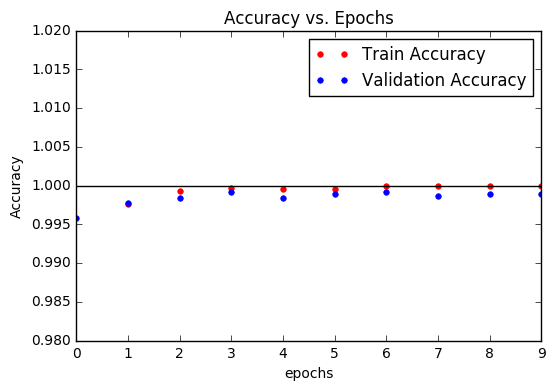

In [56]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
df = pd.DataFrame(h.history)
df['epoch'] =df.index

fig = plt.figure(1)
ax = fig.add_subplot(111)

ax.set_ylim(0.98,1.02)
ax.set_title('Accuracy vs. Epochs')
ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')

line_train, =ax.plot(np.array(df['epoch']), np.array(df['acc']), '.', color='red', markersize=8)
#plt.plot(x=np.array(df['epoch']), y=np.array(df['acc']), style='o', ylim=(0,1.1), markerfacecolor="None", markeredgecolor='red')
line_val, = ax.plot(np.array(df['epoch']), np.array(df['val_acc']), 'o',  markersize=4, markeredgecolor='blue')
ax.plot(np.array(df['epoch']), np.ones(len(df)), 'black')
ax.legend((line_train, line_val), ('Train Accuracy', 'Validation Accuracy'))
fig.savefig(sub_path + '/train_accuracy_vs_epochs10_base.png')


In [64]:
#1 BN, dropout
preds_1bn_dropout = statefarm_model.predict(mid_test_data, batch_size = batch_size)

In [68]:
#2 2 BN, dropout
preds_2bn_dropout = statefarm_model.predict(mid_test_data, batch_size = batch_size)

In [72]:
#3 No BN, dropout 20 epochs
preds_0bn_dropout1 = statefarm_model.predict(mid_test_data, batch_size = batch_size)

In [74]:
#4 No BN, dropout 40 epochs
preds_0bn_dropout2 = statefarm_model.predict(mid_test_data, batch_size = batch_size)

In [76]:
#5 No BN, dropout 100 epochs
preds_0bn_dropout3 = statefarm_model.predict(mid_test_data, batch_size = batch_size)

# Pseudo Labeling

In [45]:
test_labels = statefarm_model.predict(mid_test_data, batch_size = batch_size)

In [11]:
combo_labels = np.concatenate([train_labels, test_labels])
combo_data = np.concatenate([mid_train_data, mid_test_data])

In [13]:
print(combo_data.shape)

(97669, 25088)


In [14]:
#Construct a new model with just FCBs and using the convoluation results from Vgg16 as input
#I want to overfit the train data first, so I use 2 dense layers total 4096*4096+4096 (bias) parameters without dropout
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
lr = 0.001
statefarm_model_pseu = Sequential()
statefarm_model_pseu.add(BatchNormalization(axis=1, input_shape=(25088,)))
statefarm_model_pseu.add(Dense(256, activation='relu')) #, input_shape=(25088,)))
statefarm_model_pseu.add(BatchNormalization(axis=1))
statefarm_model_pseu.add(Dropout(0.5)) 
statefarm_model_pseu.add(Dense(10, activation='softmax'))
statefarm_model_pseu.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
statefarm_model_pseu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 25088)             100352    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 6,526,730
Trainable params: 6,476,042
Non-trainable params: 50,688
_________________________________________________________________


In [15]:
from keras.callbacks import ModelCheckpoint
#Need create train batch and validation batch
batch_size = 256

saved_weights_path = weight_path + '/pseudo_2bns_1layers_epoch_{epoch:02d}-valloss_{val_loss:.2f}.hdf5'
mcp = ModelCheckpoint(saved_weights_path, monitor='val_loss', save_weights_only=True, mode='auto', period=1)
call_backs = [mcp]
epochs = 10
h = statefarm_model_pseu.fit(combo_data, combo_labels, epochs=epochs, validation_data=(mid_val_data, val_labels), batch_size=batch_size, shuffle=True, callbacks=call_backs)

Train on 97669 samples, validate on 4481 samples
Epoch 1/10
97669/97669 [==============================] - 16s 164us/step - loss: 0.7321 - acc: 0.8329 - val_loss: 0.0280 - val_acc: 0.9958
Epoch 2/10
97669/97669 [==============================] - 16s 163us/step - loss: 0.5554 - acc: 0.8893 - val_loss: 0.0222 - val_acc: 0.9962
Epoch 3/10
97669/97669 [==============================] - 16s 164us/step - loss: 0.5244 - acc: 0.9052 - val_loss: 0.0201 - val_acc: 0.9955
Epoch 4/10
97669/97669 [==============================] - 16s 163us/step - loss: 0.5103 - acc: 0.9129 - val_loss: 0.0192 - val_acc: 0.9971
Epoch 5/10
97669/97669 [==============================] - 16s 163us/step - loss: 0.5010 - acc: 0.9184 - val_loss: 0.0185 - val_acc: 0.9962
Epoch 6/10
97669/97669 [==============================] - 16s 163us/step - loss: 0.4958 - acc: 0.9218 - val_loss: 0.0188 - val_acc: 0.9960
Epoch 7/10
97669/97669 [==============================] - 16s 163us/step - loss: 0.4915 - acc: 0.9246 - val_loss: 0.0

In [16]:
predictions = statefarm_model.predict(mid_test_data, batch_size = batch_size)

# Create Augmentated Images

In [22]:
import os
from keras.preprocessing import image

def mkdirp(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

def save_img(img_data, prefix, out_path, img_name, is_scale):
    dim_ordering = None # 'th'
    img = image.array_to_img(img_data, dim_ordering, scale=is_scale)
    fname = '{prefix}_{img_name}'.format(prefix= prefix, img_name=img_name)
    #print(out_path)
    #print("Transformed filename : %s"%fname)
    img.save(os.path.join(out_path, fname))
    
#gen= #shear_range=5, horizontal_shift=True, rotation_range = 10, shift = 0.1

#base_path = train_path
#train_path = base_path + '/train'


def create_transformed_images(base_path, transform, gen):
    print("Generating %s transforming images...."%transform)
    out_path = base_path + 'train_' + transform    
    train_path = base_path + '/train'
    mkdirp(out_path)
    batches = gen.flow_from_directory(train_path, shuffle=False, batch_size=1)
    #print('image shape: ')
    #print(batches.image_shape)
    #print('image dim_ordering: ')
    counts = len(batches.filenames)
    print('Total number of images: %d' %counts)
    for idx in range(len(batches.filenames)):
        if(idx >= 2000 and idx %2000 == 0):
            print('Processed %d'%idx)
        img = batches.filenames[idx]
        cls = img.split("/")[0]
        fn = img.split("/")[1]
        dat = batches.next()
        outp = out_path + '/' + cls
        mkdirp(outp)
        #print(len(dat))
        #print(dat[0].shape)
        #print(dat[1].shape)
        save_img(dat[0][0], transform, outp, fn, is_scale=True)        
    
    print('Completed generating %s-ed images!'%transform)
    

In [23]:
generators = {'zoom':image.ImageDataGenerator(zoom_range=0.2),
             'shear':image.ImageDataGenerator(shear_range=5),
              'wshift':image.ImageDataGenerator(width_shift_range=0.1),
              'hshift':image.ImageDataGenerator(height_shift_range=0.1),
              'rotation':image.ImageDataGenerator(rotation_range=5),
              'zcawhitening': image.ImageDataGenerator(zca_whitening=True)
             }

for transform, gen in generators.items():
    create_transformed_images(base_path, transform, gen)

Found 17943 images belonging to 10 classes.
Total number of images: 17943
Processed 2000
Processed 4000
Processed 6000
Processed 8000
Processed 10000
Processed 12000
Processed 14000
Processed 16000
Completed generating hshift-ed images!
Found 17943 images belonging to 10 classes.
Total number of images: 17943
Processed 2000
Processed 4000
Processed 6000
Processed 8000
Processed 10000
Processed 12000
Processed 14000
Processed 16000
Completed generating wshift-ed images!
Found 17943 images belonging to 10 classes.
Total number of images: 17943
Processed 2000
Processed 4000
Processed 6000
Processed 8000
Processed 10000
Processed 12000
Processed 14000
Processed 16000
Completed generating zoom-ed images!
Found 17943 images belonging to 10 classes.
Total number of images: 17943
Processed 2000
Processed 4000
Processed 6000
Processed 8000
Processed 10000
Processed 12000
Processed 14000
Processed 16000
Completed generating rotation-ed images!
Found 17943 images belonging to 10 classes.
Total nu

# Pre-train CNN layers with VGG16

In [24]:
import vgg16; reload(vgg16)
vggm = vgg16.Vgg16()
#Remove dense layers, only keep convolution layers
vggm.model.pop() #dense6
vggm.model.pop() #dropout4
vggm.model.pop() #dense5
vggm.model.pop() #dropout3
vggm.model.pop() #dense4
vggm.compile() 
vggm.model.summary()


vgg16.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  model.add(Conv2D(filters, 3, 3, activation='relu'))
vgg16.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  model.add(Conv2D(filters, 3, 3, activation='relu'))
vgg16.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  model.add(Conv2D(filters, 3, 3, activation='relu'))
vgg16.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu")`
  model.add(Conv2D(filters, 3, 3, activation='relu'))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [26]:
batch_size = 60
for transform in generators.keys():
    print("Computing CNN output features for %s"%transform)
    t_path = base_path +'/train_' + transform
    t_batches, t_predictions = vggm.test(t_path, batch_size)
    utils.save_array(weight_path + '/statefarm_' + transform, t_predictions)

Computing CNN output features for hshift
Found 17943 images belonging to 10 classes.
Computing CNN output features for wshift
Found 17943 images belonging to 10 classes.
Computing CNN output features for zoom
Found 17943 images belonging to 10 classes.
Computing CNN output features for rotation
Found 17943 images belonging to 10 classes.
Computing CNN output features for zcawhitening
Found 17943 images belonging to 10 classes.
Computing CNN output features for shear
Found 17943 images belonging to 10 classes.


(17943, 25088)


# Apply Pre-Trained CNN to Augmented Images

In [30]:
import utils
transformed_train_data = None
for transform in generators.keys():
    weight_p = weight_path + '/statefarm_' + transform
    t = utils.load_array(weight_p)
    if transformed_train_data is None:
        transformed_train_data = t
    else:
        transformed_train_data = np.concatenate([transformed_train_data, t])

transformed_train_data = np.concatenate([transformed_train_data, mid_train_data])    

In [31]:
transformed_train_labels = np.concatenate([train_labels, train_labels,train_labels,train_labels,train_labels,train_labels, train_labels])
print(transformed_train_data.shape)
print(transformed_train_labels.shape)

(125601, 25088)
(125601, 10)


In [32]:
#Construct a new model with just FCBs and using the convoluation results from Vgg16 as input
#I want to overfit the train data first, so I use 2 dense layers total 4096*4096+4096 (bias) parameters without dropout
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
lr = 0.001
statefarm_model_pseu = Sequential()
statefarm_model_pseu.add(BatchNormalization(axis=1, input_shape=(25088,)))
statefarm_model_pseu.add(Dense(256, activation='relu')) #, input_shape=(25088,)))
statefarm_model_pseu.add(BatchNormalization(axis=1))
statefarm_model_pseu.add(Dropout(0.5)) 
statefarm_model_pseu.add(Dense(10, activation='softmax'))
statefarm_model_pseu.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
statefarm_model_pseu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 25088)             100352    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6422784   
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 6,526,730
Trainable params: 6,476,042
Non-trainable params: 50,688
_________________________________________________________________


In [33]:
from keras.callbacks import ModelCheckpoint
#Need create train batch and validation batch
batch_size = 256

saved_weights_path = weight_path + '/aug_2bns_1layers_epoch_{epoch:02d}-valloss_{val_loss:.2f}.hdf5'
mcp = ModelCheckpoint(saved_weights_path, monitor='val_loss', save_weights_only=True, mode='auto', period=1)
call_backs = [mcp]
epochs = 10
h = statefarm_model_pseu.fit(transformed_train_data, transformed_train_labels, epochs=epochs, validation_data=(mid_val_data, val_labels), batch_size=batch_size, shuffle=True, callbacks=call_backs)

Train on 125601 samples, validate on 4481 samples
Epoch 1/10
125601/125601 [==============================] - 20s 161us/step - loss: 0.2897 - acc: 0.9121 - val_loss: 0.0090 - val_acc: 0.9975
Epoch 2/10
125601/125601 [==============================] - 20s 159us/step - loss: 0.1108 - acc: 0.9642 - val_loss: 0.0064 - val_acc: 0.9978
Epoch 3/10
125601/125601 [==============================] - 20s 159us/step - loss: 0.0766 - acc: 0.9744 - val_loss: 0.0061 - val_acc: 0.9984
Epoch 4/10
125601/125601 [==============================] - 20s 158us/step - loss: 0.0591 - acc: 0.9805 - val_loss: 0.0046 - val_acc: 0.9989
Epoch 5/10
125601/125601 [==============================] - 20s 158us/step - loss: 0.0451 - acc: 0.9854 - val_loss: 0.0058 - val_acc: 0.9984
Epoch 6/10
125601/125601 [==============================] - 20s 158us/step - loss: 0.0391 - acc: 0.9872 - val_loss: 0.0073 - val_acc: 0.9980
Epoch 7/10
125601/125601 [==============================] - 20s 158us/step - loss: 0.0328 - acc: 0.9892 

In [34]:
predictions = statefarm_model_pseu.predict(mid_test_data, batch_size = batch_size)

In [ ]:
# Augmented + Pseudo Labels

In [47]:
print(test_labels.shape)
combo_aug_pseudo_labels = np.concatenate([transformed_train_labels, test_labels])
combo_aug_pseudo_data = np.concatenate([transformed_train_data, mid_test_data])

(79726, 10)


In [48]:
from keras.callbacks import ModelCheckpoint
#Need create train batch and validation batch
batch_size = 256

saved_weights_path = weight_path + '/aug_pseudo_2bns_1layers_epoch_{epoch:02d}-valloss_{val_loss:.2f}.hdf5'
mcp = ModelCheckpoint(saved_weights_path, monitor='val_loss', save_weights_only=True, mode='auto', period=1)
call_backs = [mcp]
epochs = 10
h = statefarm_model_pseu.fit(combo_aug_pseudo_data, combo_aug_pseudo_labels, epochs=epochs, validation_data=(mid_val_data, val_labels), batch_size=batch_size, shuffle=True, callbacks=call_backs)

Train on 205327 samples, validate on 4481 samples
Epoch 1/10
205327/205327 [==============================] - 32s 158us/step - loss: 0.3385 - acc: 0.9237 - val_loss: 0.0108 - val_acc: 0.9973
Epoch 2/10
205327/205327 [==============================] - 32s 157us/step - loss: 0.2777 - acc: 0.9433 - val_loss: 0.0094 - val_acc: 0.9975
Epoch 3/10
205327/205327 [==============================] - 32s 158us/step - loss: 0.2643 - acc: 0.9491 - val_loss: 0.0076 - val_acc: 0.9978
Epoch 4/10
205327/205327 [==============================] - 32s 158us/step - loss: 0.2582 - acc: 0.9522 - val_loss: 0.0079 - val_acc: 0.9975
Epoch 5/10
205327/205327 [==============================] - 33s 159us/step - loss: 0.2529 - acc: 0.9543 - val_loss: 0.0072 - val_acc: 0.9980
Epoch 6/10
205327/205327 [==============================] - 33s 158us/step - loss: 0.2484 - acc: 0.9568 - val_loss: 0.0068 - val_acc: 0.9982
Epoch 7/10
205327/205327 [==============================] - 37s 179us/step - loss: 0.2451 - acc: 0.9590 

# Ensemble

In [96]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([[8,2,5],[2,5,6]])
print(a)
print(b)
avg =(a + b)/2.0
print(avg)

predictions = (preds_1bn_dropout+preds_2bn_dropout+preds_0bn_dropout1+preds_0bn_dropout2+preds_0bn_dropout3)/5

[[1 2 3]
 [4 5 6]]
[[8 2 5]
 [2 5 6]]
[[ 4.5  2.   4. ]
 [ 3.   5.   6. ]]


In [55]:
wp = weight_path + '/'
ws = ['aug_pseudo_2bns_1layers_epoch_10-valloss_0.01.hdf5', 
     'aug_2bns_1layers_epoch_10-valloss_0.01.hdf5', 'pseudo_2bns_1layers_epoch_10-valloss_0.02.hdf5',]

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
lr = 0.001
testm = Sequential()
testm.add(BatchNormalization(axis=1, input_shape=(25088,)))
testm.add(Dense(256, activation='relu')) #, input_shape=(25088,)))
testm.add(BatchNormalization(axis=1))
testm.add(Dropout(0.5)) 
testm.add(Dense(10, activation='softmax'))
testm.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
#testm.summary()

predictions = None
for w in ws:
    testm.load_weights(wp + w)
    preds = testm.predict(mid_test_data, batch_size = batch_size)
    if predictions is None:
        predictions = preds
    else:
        predictions = predictions + preds

predictions = predictions/len(ws)

3

In [49]:
predictions = statefarm_model_pseu.predict(mid_test_data, batch_size = batch_size)

# Create Submission File

In [56]:
def do_clip(arr, mx): 
    return np.clip(arr, (1-mx)/9, mx)

def get_id(img_path):
    fid = img_path.split("/")[1] #Get image ID
    return fid

s = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'] #train_data.class_indices.keys()
s.sort()
df = pd.DataFrame(predictions, columns=s)
for c in s:
    df[c] = do_clip(df[c], 0.93)
df['img'] = test_filenames #test_batches.filenames
df['img'] = df.apply(lambda r: get_id(r['img']), axis=1)
cols = cols = ['img'] + s
df = df[cols]
#print(df)
fn = "./sub/statefarm/ensemble_aug_pseu_batchsize_" + str(batch_size) + "_epochs" + str(epochs) +"_.csv"
df.to_csv(fn, index=False)
print("Write to " + fn)
print("DONE!")
from IPython.display import FileLink
FileLink(fn)  

Write to ./sub/statefarm/ensemble_aug_pseu_batchsize_256_epochs10_.csv
DONE!


/home/ubuntu/fastai_course/neilz/part1/sub/statefarm/ensemble_aug_pseu_batchsize_256_epochs10_.csv